<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Amir Hosein Rahmati
### Student Number : 99103922
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [86]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
from sklearn.metrics import confusion_matrix
import seaborn as sn


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [9]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [10]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [71]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=128, shuffle=False)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [72]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1), # 28x28x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 14x14x16

        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1), # 14x14x16
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1), # 14x14x16
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2), # 7x7x16
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1), # 7x7x64
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), # 7x7x64
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), # 7x7x64
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.linear = nn.Sequential(
            # use gloabal average pooling to reduce the dimensionality to 64x1x1
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64, 10),
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Softmax(dim=1)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = x + self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv4(x)
        x = self.linear(x)
        return x

# Train Model (30 Points)

In [76]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001 , weight_decay=1e-5)

In [77]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 10

train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_model = None
best_acc = 0.0

for epoch in range(num_epochs):
    train_loss = 0.0
    n = 0
    model.train()
    acc= 0
    with tqdm(train_loader, unit='batch') as torch_epoch:
        for img, y in torch_epoch:
            img = img.to(device)
            y = y.to(device)
            # going forward and calculate loss
            out = model(img)
            loss = criterion(out, y)
            train_loss += loss.item()
            n += 1
            # going backward and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # calculate accuracy  
            predicted = torch.argmax(out, dim=1)
            acc += (predicted == y).sum().item() / len(y)
            torch_epoch.set_description(f'Train {epoch} | Loss:{train_loss/n:.3e} | Acc: {acc/n:.3f}|')
    
    train_losses.append(train_loss/n)
    train_accs.append(acc)

    # validate model
    val_loss = 0.0
    n = 0
    model.eval()
    acc= 0
    with tqdm(val_loader, unit='batch') as torch_epoch:
        for img, y in torch_epoch:
            img = img.to(device)
            y = y.to(device)
            # going forward and calculate loss
            out = model(img)
            loss = criterion(out, y)
            val_loss += loss.item()
            n += 1
            # calculate accuracy  
            predicted = torch.argmax(out, dim=1)
            acc += (predicted == y).sum().item() / len(y)
            torch_epoch.set_description(f'Val {epoch} | Loss:{val_loss/n:.3e} | Acc: {acc/n:.3f}|')
    
    val_losses.append(val_loss/n)
    val_accs.append(acc)
    print(f'----------------------------[Epoch{epoch} finished!]----------------------------')

Train 0 | Loss:2.256e+00 | Acc: 0.922|: 100%|██████████| 391/391 [00:12<00:00, 31.76batch/s]
Val 0 | Loss:2.250e+00 | Acc: 0.977|: 100%|██████████| 79/79 [00:01<00:00, 39.78batch/s]


----------------------------[Epoch0 finished!]----------------------------


Train 1 | Loss:2.249e+00 | Acc: 0.985|: 100%|██████████| 391/391 [00:12<00:00, 32.00batch/s]
Val 1 | Loss:2.249e+00 | Acc: 0.983|: 100%|██████████| 79/79 [00:01<00:00, 39.63batch/s]


----------------------------[Epoch1 finished!]----------------------------


Train 2 | Loss:2.249e+00 | Acc: 0.989|: 100%|██████████| 391/391 [00:12<00:00, 31.55batch/s]
Val 2 | Loss:2.249e+00 | Acc: 0.987|: 100%|██████████| 79/79 [00:01<00:00, 40.10batch/s]


----------------------------[Epoch2 finished!]----------------------------


Train 3 | Loss:2.249e+00 | Acc: 0.991|: 100%|██████████| 391/391 [00:12<00:00, 31.76batch/s]
Val 3 | Loss:2.249e+00 | Acc: 0.989|: 100%|██████████| 79/79 [00:02<00:00, 39.35batch/s]


----------------------------[Epoch3 finished!]----------------------------


Train 4 | Loss:2.249e+00 | Acc: 0.992|: 100%|██████████| 391/391 [00:12<00:00, 31.95batch/s]
Val 4 | Loss:2.249e+00 | Acc: 0.987|: 100%|██████████| 79/79 [00:01<00:00, 39.65batch/s]


----------------------------[Epoch4 finished!]----------------------------


Train 5 | Loss:2.249e+00 | Acc: 0.993|: 100%|██████████| 391/391 [00:12<00:00, 31.64batch/s]
Val 5 | Loss:2.249e+00 | Acc: 0.990|: 100%|██████████| 79/79 [00:02<00:00, 38.07batch/s]


----------------------------[Epoch5 finished!]----------------------------


Train 6 | Loss:2.248e+00 | Acc: 0.993|: 100%|██████████| 391/391 [00:12<00:00, 31.94batch/s]
Val 6 | Loss:2.249e+00 | Acc: 0.989|: 100%|██████████| 79/79 [00:01<00:00, 39.53batch/s]


----------------------------[Epoch6 finished!]----------------------------


Train 7 | Loss:2.248e+00 | Acc: 0.994|: 100%|██████████| 391/391 [00:12<00:00, 31.19batch/s]
Val 7 | Loss:2.249e+00 | Acc: 0.989|: 100%|██████████| 79/79 [00:01<00:00, 39.54batch/s]


----------------------------[Epoch7 finished!]----------------------------


Train 8 | Loss:2.248e+00 | Acc: 0.995|: 100%|██████████| 391/391 [00:12<00:00, 31.89batch/s]
Val 8 | Loss:2.249e+00 | Acc: 0.987|: 100%|██████████| 79/79 [00:02<00:00, 39.21batch/s]


----------------------------[Epoch8 finished!]----------------------------


Train 9 | Loss:2.248e+00 | Acc: 0.995|: 100%|██████████| 391/391 [00:12<00:00, 31.97batch/s]
Val 9 | Loss:2.249e+00 | Acc: 0.990|: 100%|██████████| 79/79 [00:01<00:00, 40.73batch/s]

----------------------------[Epoch9 finished!]----------------------------


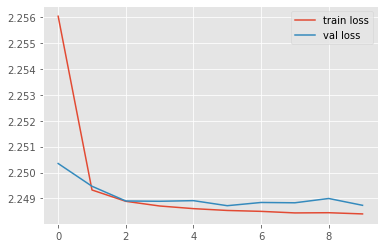

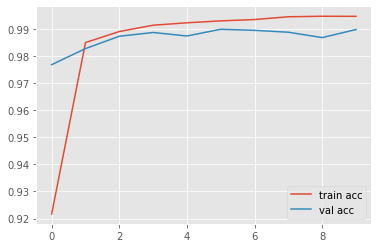

In [81]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
# plot loss in each epoch
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

# plot accuracy in each epoch
plt.plot([i/391 for i in train_accs], label='train acc')
plt.plot([i/79 for i in val_accs], label='val acc')
plt.legend()
plt.show()



# Test Model (20 Points)

In [84]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=False)
print(len(test_data))

test_loss = 0.0
n = 0
acc = 0
model.eval()
# we want to see the overall performance of the model on the test set so we use all the test data together
with tqdm(test_loader,unit='batch') as torch_epoch:
    for x, y in torch_epoch:
        x = x.to(device)
        y = y.to(device)
        # going forward and calculate loss
        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()
        n += 1
        # calculate accuracy  
        predicted = torch.argmax(out, dim=1)
        acc += (predicted == y).sum().item() / len(y)
        torch_epoch.set_description(f'Test | Loss:{test_loss/n:.3e} | Acc: {acc/n:.3f}|')


10000


Test | Loss:2.249e+00 | Acc: 0.991|: 100%|██████████| 1/1 [00:01<00:00,  1.65s/batch]


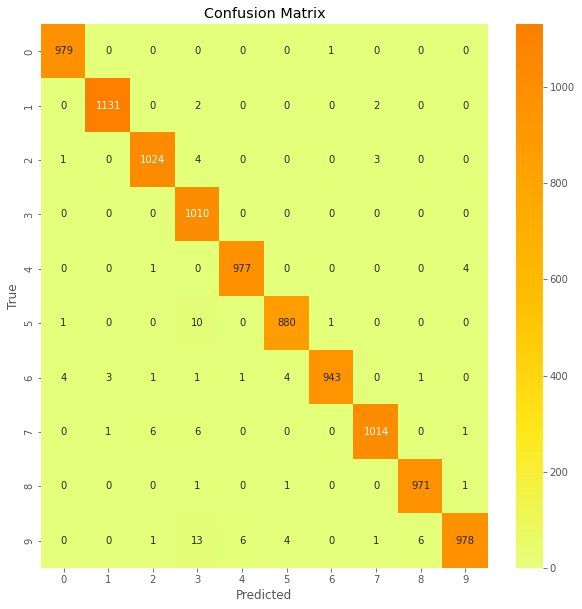

In [87]:
# plot confusion matrix
confusion = confusion_matrix(y.cpu(), predicted.cpu())
plt.figure(figsize=(10,10))
plt.title('Confusion Matrix')
sn.heatmap(confusion, annot=True, fmt='d', cmap="Wistia")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()